# Module import

In [252]:
from netCDF4 import Dataset                             
import numpy as np                                      
import matplotlib.pyplot as plt           
import matplotlib.colors as mcolors              
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature     
import cartopy.io.shapereader as shpreader
import sys
import torch 
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import os
from scipy.ndimage import gaussian_filter

In [253]:
sys.path.append("/home/users/mendrika/Object-Based-LSTMConv/notebooks/model/training")
from obconvlstm_highres_small import OB2MapModel

# Choose nowcast origin and lead time (in hour)

In [254]:
year = "2021"
month = "07"
day = "15"
hour = "13"
minute = "00"

In [255]:
lead_time = 6

# Configurations

## Zambia extent

In [256]:
DISPLAY_LON_MIN = -18.5
DISPLAY_LON_MAX = -4.45
DISPLAY_LAT_MIN = 5.1
DISPLAY_LAT_MAX = 19.5

# Ground truth 

In [257]:
def update_hour(date_dict, hours_to_add, minutes_to_add):
    """
    Add hours and minutes to a datetime dictionary and return the updated dict and a generated file path.

    Args:
        date_dict     (dict): Keys: 'year', 'month', 'day', 'hour', 'minute' as strings, e.g. "01", "23"
        hours_to_add   (int): Number of hours to add.
        minutes_to_add (int): Number of minutes to add.

    Returns:
        tuple:
            - dict: Updated datetime dictionary with all fields as zero-padded strings.
            - str: File path in the format YYYY/MM/YYYYMMDDHHMM.nc
    """
    # Parse the original time
    time_obj = datetime(
        int(date_dict["year"]),
        int(date_dict["month"]),
        int(date_dict["day"]),
        int(date_dict["hour"]),
        int(date_dict["minute"])
    )

    # Add hours
    updated = time_obj + timedelta(hours=hours_to_add, minutes=minutes_to_add)

    # Format updated dictionary
    new_date_dict = {
        "year":   f"{updated.year:04d}",
        "month":  f"{updated.month:02d}",
        "day":    f"{updated.day:02d}",
        "hour":   f"{updated.hour:02d}",
        "minute": f"{updated.minute:02d}"
    }

    # Generate file path
    file_path = f"{new_date_dict['year']}/{new_date_dict['month']}/{new_date_dict['year']}{new_date_dict['month']}{new_date_dict['day']}{new_date_dict['hour']}{new_date_dict['minute']}.nc"

    return {'time': new_date_dict, 'path': file_path}

In [258]:
def load_wavelet_dataset(year, month, day, hour, minute, lead_time):
    
    nowcast_origin = {
        "year":   year,
        "month":  month,
        "day":    day,
        "hour":   hour,
        "minute": minute,
    }

    nowcast_lt = update_hour(nowcast_origin, hours_to_add=lead_time, minutes_to_add=0)["time"]

    path_core = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{nowcast_lt['year']}/{nowcast_lt['month']}"
    file = f"{path_core}/{nowcast_lt['year']}{nowcast_lt['month']}{nowcast_lt['day']}{nowcast_lt['hour']}{nowcast_lt['minute']}.nc"
    return Dataset(file, mode='r')["cores"]

In [259]:
y_min, y_max = 1403, 1914
x_min, x_max = 66, 577

In [260]:
ground_truth = load_wavelet_dataset(year, month, day, hour, minute, lead_time)[0, y_min:y_max+1, x_min:x_max+1] != 0

In [261]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][y_min:y_max+1, x_min:x_max+1]
lats = geodata["lat"][y_min:y_max+1, x_min:x_max+1]

In [262]:
def load_zcast_input(year, month, day, hour, minute, lead_time):
    input_path_zcast = f"/work/scratch-nopw2/mendrika/OB/raw/inputs_t0"
    core_input = f"{input_path_zcast}/input-{year}{month}{day}_{hour}{minute}.pt"
    return torch.load(core_input)

In [263]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [264]:
ENSEMBLE_DIR = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/lstm_core2map_hybrid/latent32_fss3/t{lead_time}"

In [265]:
N_MC = 10  # number of MC dropout samples per model

def enable_dropout(model, p=0.3):
    # keep dropout active during inference
    for m in model.modules():
        if isinstance(m, (torch.nn.Dropout, torch.nn.Dropout2d)):
            m.train()
            m.p = p

def load_models(ensemble_dir):
    models = []
    for seed in sorted(os.listdir(ensemble_dir)):
        ckpt = os.path.join(ensemble_dir, seed, "best-core2map.ckpt")
        if os.path.exists(ckpt):
            model = OB2MapModel.load_from_checkpoint(ckpt, map_location=DEVICE)
            model.eval().to(DEVICE)
            models.append(model)
            print(f"Loaded {ckpt}")
    return models


def mc_predict(model, x, n_samples=10):
    # enable dropout layers
    enable_dropout(model)

    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            preds.append(torch.sigmoid(model(x)/1.2))   
    preds = torch.stack(preds)                      # (n_samples, B, H, W)

    return preds.mean(0), preds.var(0)


def ensemble_mc_predict(models, x, n_mc=N_MC):
    mean_list, var_list = [], []

    for m in models:
        mean_i, var_i = mc_predict(m, x, n_mc)
        mean_list.append(mean_i)
        var_list.append(var_i)

    mean_stack = torch.stack(mean_list)  # (N_models, B, H, W)
    var_stack = torch.stack(var_list)    # (N_models, B, H, W)

    # ensemble mean
    mean_ens = mean_stack.mean(0)

    # total variance = epistemic + aleatoric
    var_ens = var_stack.mean(0) + mean_stack.var(0)

    return mean_ens, var_ens


In [266]:
models = load_models(ENSEMBLE_DIR)
print(f"Loaded {len(models)} ensemble members.")

Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/lstm_core2map_hybrid/latent32_fss3/t6/seed1/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/lstm_core2map_hybrid/latent32_fss3/t6/seed134/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/lstm_core2map_hybrid/latent32_fss3/t6/seed1998/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/lstm_core2map_hybrid/latent32_fss3/t6/seed2025/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/lstm_core2map_hybrid/latent32_fss3/t6/seed676/best-core2map.ckpt
Loaded 5 ensemble members.


In [267]:
SCALER_PATH = "/home/users/mendrika/Object-Based-LSTMConv/outputs/scaler/scaler_realcores.pt"

MASK_COL_INDEX = 12
COLS_TO_SCALE = range(4, 12)

# load scaler
scaler = torch.load(SCALER_PATH, weights_only=False)
mean = np.asarray(scaler["mean"])
scale = np.asarray(scaler["scale"])

try:
    # load one instance
    zcast_input = load_zcast_input(year, month, day, hour, minute, lead_time)

    # shape: (5, 50, 13) → add batch dim → (1, 5, 50, 13)
    input_tensor = zcast_input["input_tensor"].clone().unsqueeze(0)

    # remove batch dim for scaling
    X = input_tensor[0]

    # convert to numpy
    X_np = X.numpy()

    # reshape to (250, 13)
    flat = X_np.reshape(-1, X_np.shape[-1])

    # scale all cores (real + padded)
    flat[:, COLS_TO_SCALE] = (flat[:, COLS_TO_SCALE] - mean) / scale

    # reshape back to (5, 50, 13)
    X_scaled = torch.tensor(flat.reshape(X_np.shape), dtype=torch.float32)

    # re-add batch dimension → (1, 5, 50, 13)
    input_scaled = X_scaled.unsqueeze(0)

    mean_pred, var_pred = ensemble_mc_predict(models, input_scaled.to(DEVICE))

except:
    print("No data")
    mean_pred = np.zeros((1, 1, 512, 512))

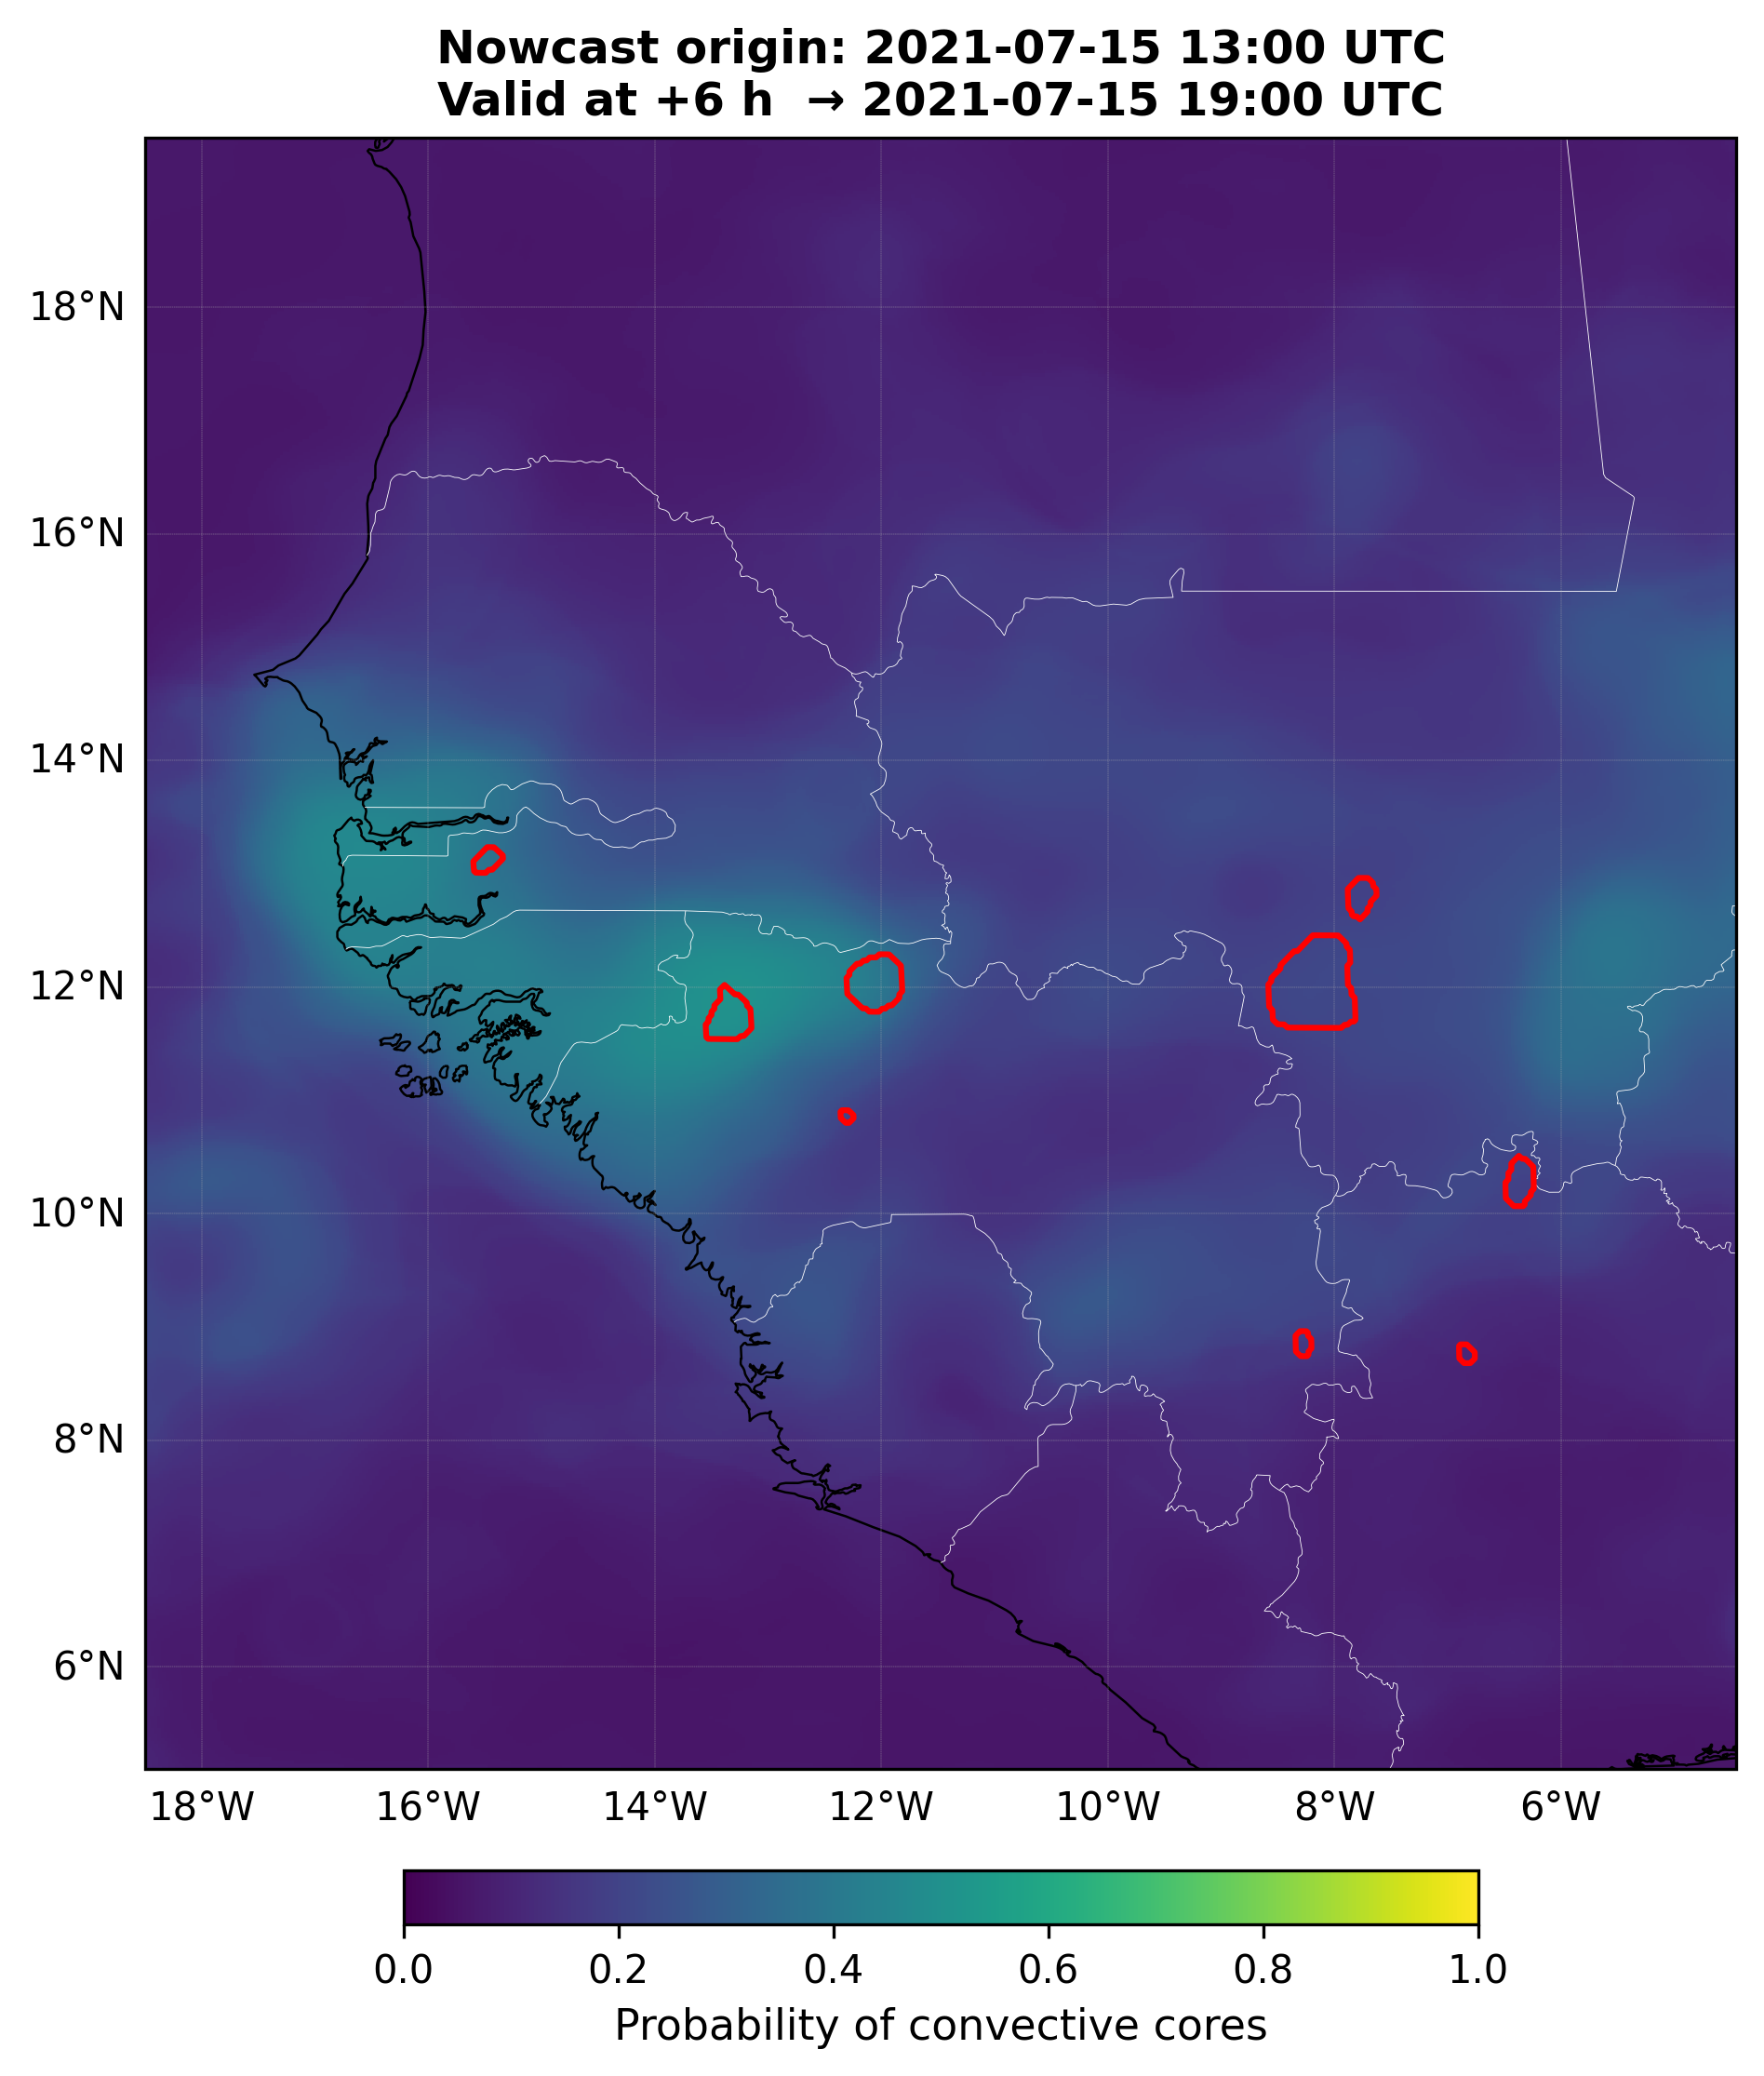

In [268]:
# compute origin and valid time
origin_dt = datetime(int(year), int(month), int(day), int(hour), int(minute))
valid_dt = origin_dt + timedelta(hours=lead_time)

# build title string
title_str = (
    f"Nowcast origin: {origin_dt:%Y-%m-%d %H:%M UTC}\n"
    f"Valid at +{lead_time} h  → {valid_dt:%Y-%m-%d %H:%M UTC}"
)

# create figure and axis
fig, ax = plt.subplots(
    1, 1, figsize=(8, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

# extent from Zambia style
ax.set_extent(
    [
        DISPLAY_LON_MIN,
        DISPLAY_LON_MAX,
        DISPLAY_LAT_MIN,
        DISPLAY_LAT_MAX
    ],
    crs=ccrs.PlateCarree()
)

# Zambia-style base map features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2)

# Western Sahel-style gridlines (only change)
gl = ax.gridlines(
    draw_labels=True,
    alpha=1,
    linestyle='--',
    linewidth=0.1
)
gl.top_labels = False
gl.right_labels = False

# mask weak probabilities
ZCAST_masked = np.ma.masked_where(mean_pred <= 0, mean_pred)

# ZCAST background
im = ax.pcolormesh(
    lons,
    lats,
    ZCAST_masked.squeeze(0).squeeze(0),
    cmap='viridis',
    vmin=0,
    vmax=1,
    transform=ccrs.PlateCarree(),
    zorder=1
)

# smooth ground truth
gt_smooth = gaussian_filter(ground_truth.astype(float), sigma=0.4)

# red contour
ax.contour(
    lons,
    lats,
    gt_smooth,
    levels=[0.5],
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# colourbar
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.set_label('Probability of convective cores', fontsize=11)

# title
ax.set_title(title_str, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


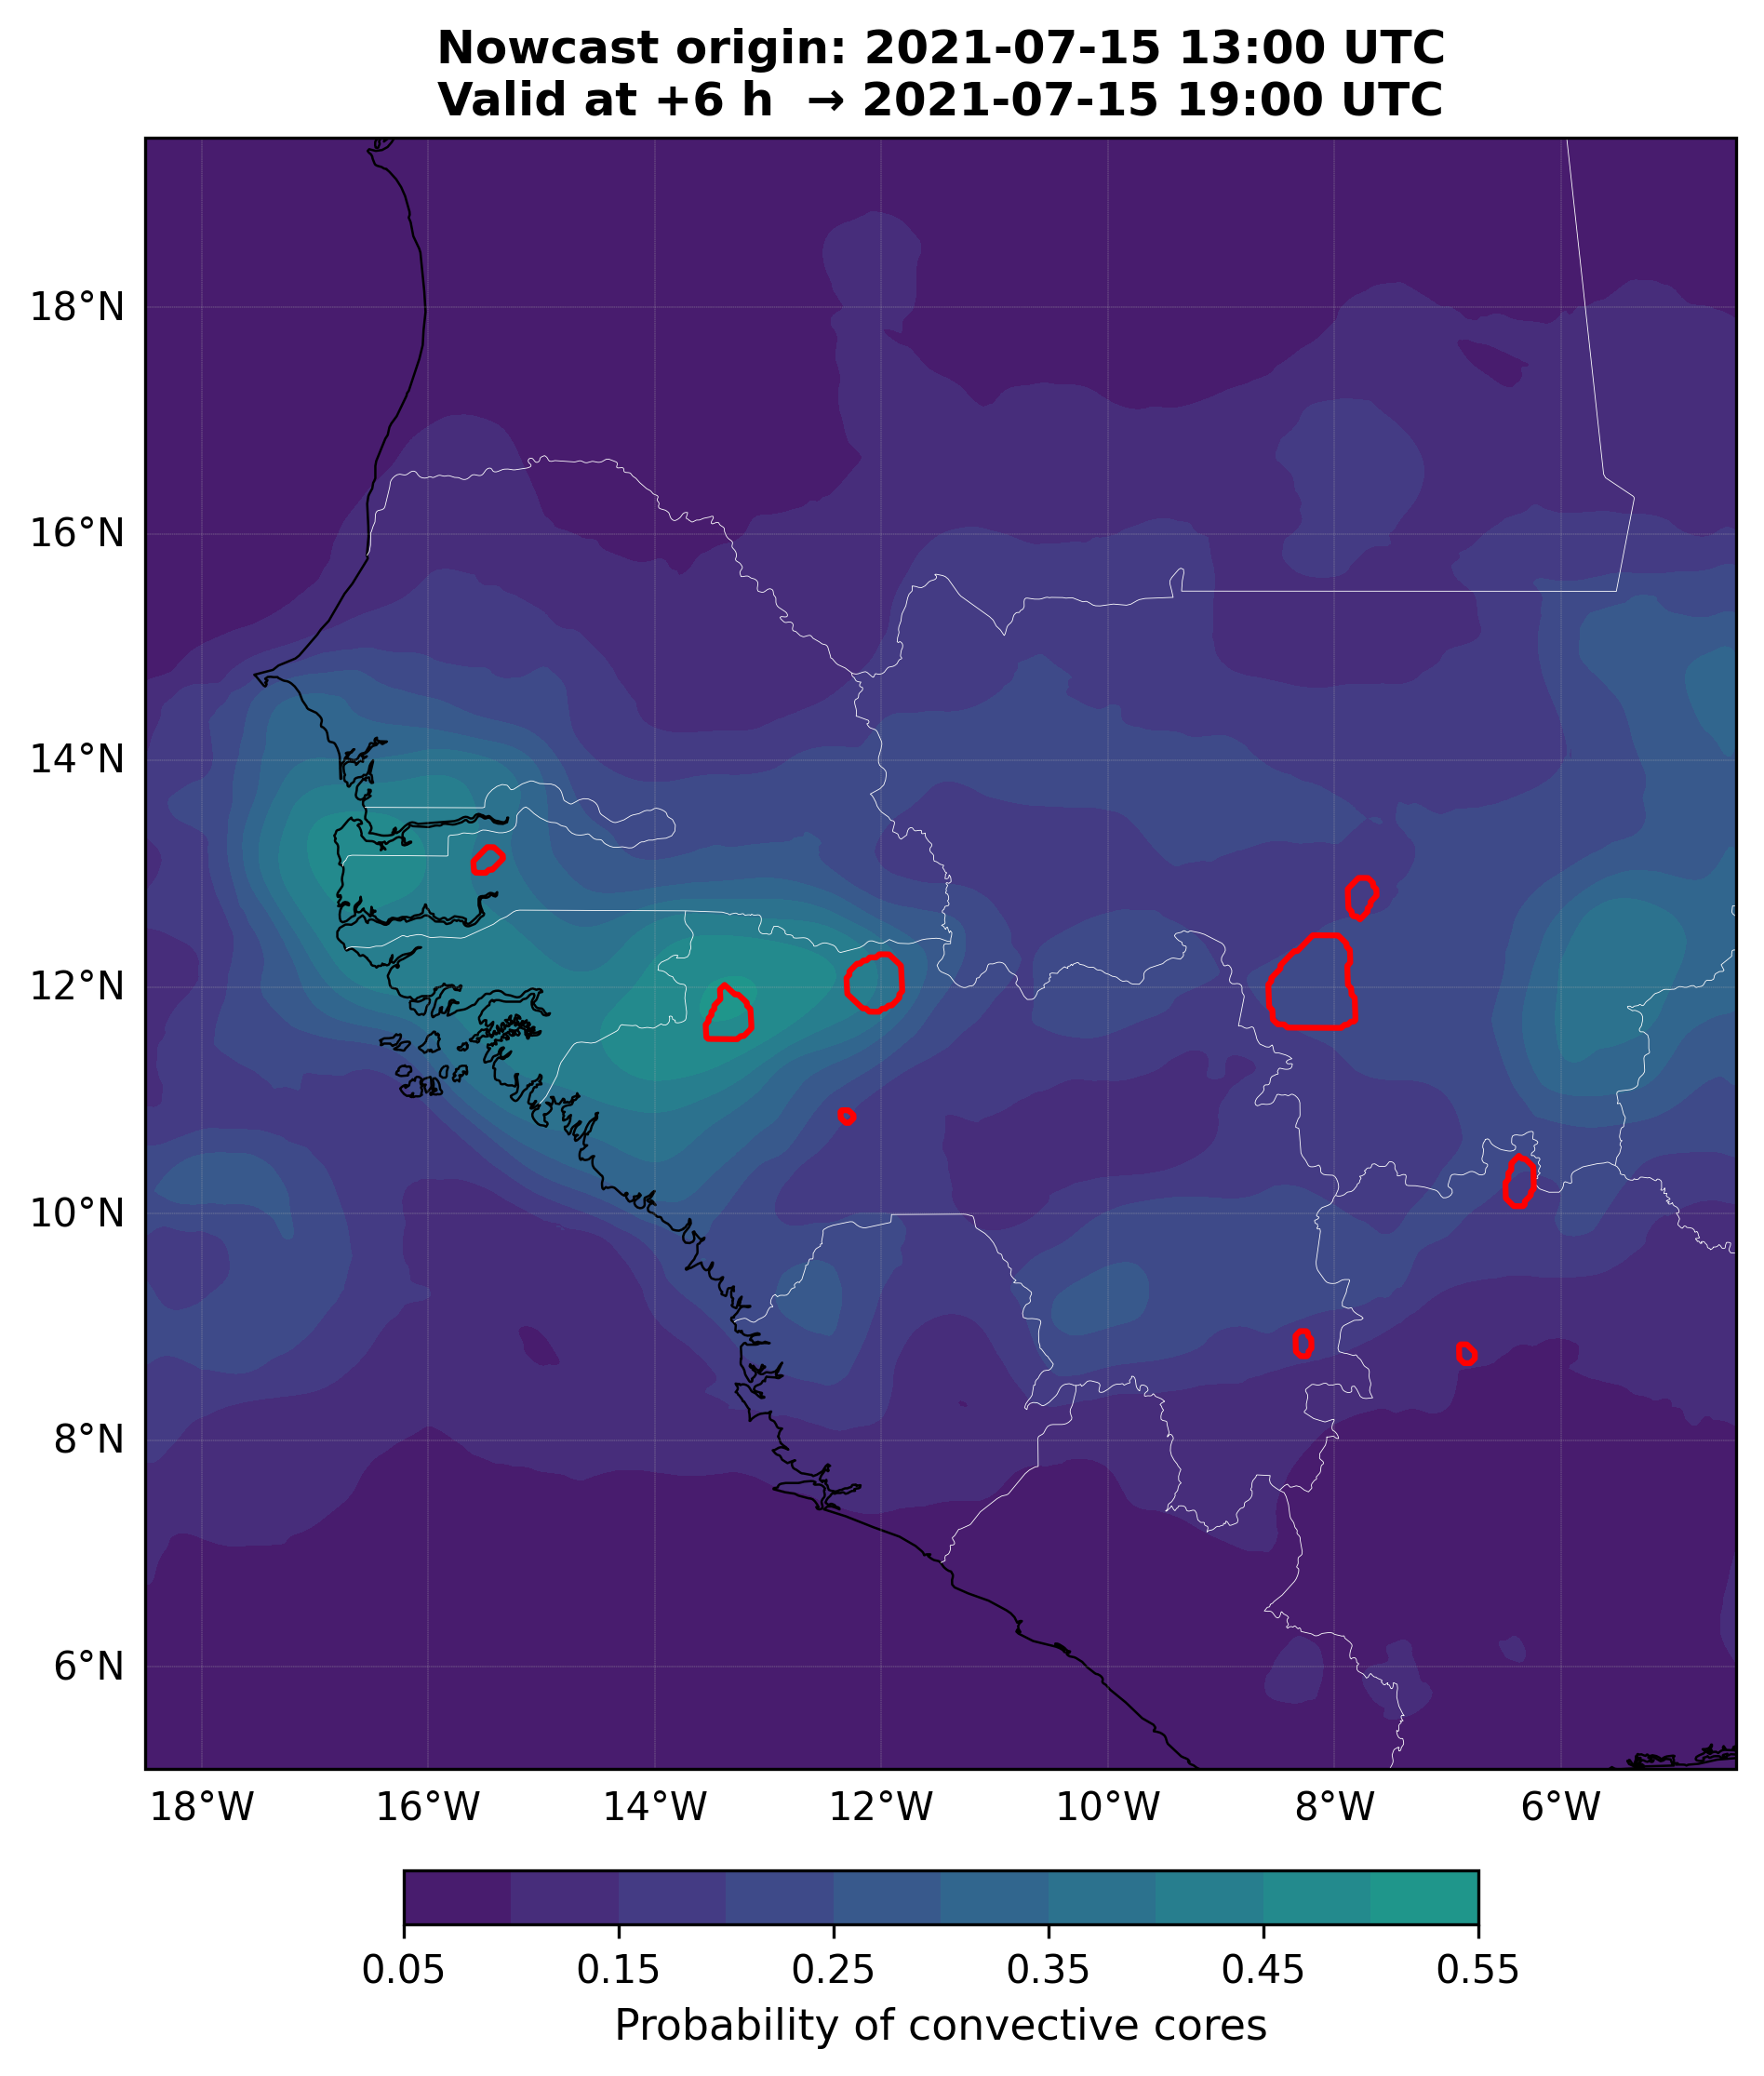

In [271]:
# create figure and axis
fig, ax = plt.subplots(
    1, 1, figsize=(8, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

# set extent
ax.set_extent(
    [
        DISPLAY_LON_MIN,
        DISPLAY_LON_MAX,
        DISPLAY_LAT_MIN,
        DISPLAY_LAT_MAX
    ],
    crs=ccrs.PlateCarree()
)

# base map features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2)

# western sahel gridlines
gl = ax.gridlines(
    draw_labels=True,
    alpha=1,
    linestyle='--',
    linewidth=0.1
)
gl.top_labels = False
gl.right_labels = False

# mask weak predictions
ZCAST_masked = np.ma.masked_where(mean_pred <= 0, mean_pred)

# filled contours for probability
im = ax.contourf(
    lons,
    lats,
    ZCAST_masked.squeeze(0).squeeze(0),
    cmap='viridis',
    levels=10,
    vmin=0,
    vmax=1,
    transform=ccrs.PlateCarree(),
    zorder=1
)

# smooth binary ground truth
gt_smooth = gaussian_filter(ground_truth.astype(float), sigma=0.4)

# red outline of observed storms
ax.contour(
    lons,
    lats,
    gt_smooth,
    levels=[0.5],
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# colourbar
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='horizontal',
    shrink=0.5,
    pad=0.05
)
cbar.set_label('Probability of convective cores', fontsize=11)

# title
ax.set_title(title_str, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()